In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from random import random
from collections import Counter
from rdkit.Chem import Draw
from rdkit import Chem

ETHcolors = [(33,92,175), (0,120,148), (98,115,19), (142,103,19), (183,53,45), (163,7,116), (111,111,111)]
ETHcolors = [f"#{r:02x}{g:02x}{b:02x}" for r,g,b in ETHcolors]

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

output_directory = None

In [2]:
def plot_comparison(ax, ax_err, pos, name, error_comps, legend=False):
    with open(f'{name}_comparison.json') as f:
        comparison = json.load(f)
    comparison.sort(key=lambda r: r['result']['target'])

    all_chemicals = set(comp['chemical'] for comp in comparison)

    symbols = ['o', 'v', 'p', 'X', '*', 'D', 'h']

    colors = dict(zip(sorted(all_chemicals), zip(ETHcolors, symbols)))

    if legend:
        for l,c in colors.items():
            ax.plot(0, 0, c[1], label=l, color=c[0])

    iupac = None
    i = 0
    error = []
    for comp in comparison:
        if iupac is not None and comp['iupac_name'] == iupac:
            continue
        iupac = comp['iupac_name']
        i += 1
        if comp['target_pcsaft'] is not None:
            ax.plot([i]*2, [-comp['target_pcsaft'], -comp['result']['target']], '-', color=colors[comp['chemical']][0])
        ax.plot(i, -comp['result']['target'], colors[comp['chemical']][1], markerfacecolor='w', markeredgecolor=colors[comp['chemical']][0])
        if comp['target_pcsaft'] is not None:
            ax.plot(i, -comp['target_pcsaft'], colors[comp['chemical']][1], color=colors[comp['chemical']][0])
            if iupac in error_comps:
                error.append(abs((comp['result']['target']-comp['target_pcsaft'])/comp['target_pcsaft'])*100)
            #print(f'{name:9} {iupac:30} {error[-1]}')
    if legend:
        ax.legend(bbox_to_anchor=(0,1.02,1,0.2), mode='expand', ncol=7, handletextpad=0, frameon=False)
    if not legend:
        ax.set_xlabel('ranking')
    ax.set_ylabel('$P_\\mathrm{net}~~/~~\mathrm{kW}$')
    ax.axis([0,48,84,94])
    ax.text(0.02, 0.1, {'pcsaft': 'PC-SAFT (homosegmented)', 'gc-pcsaft': 'gc-PC-SAFT (heterosegmented)'}[name], horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes, fontsize=14)
    
    parts = ax_err.violinplot(error, [pos], showmedians=True, showextrema=True)
    for key, pc in parts.items():
        if key == 'bodies':
            for pc in parts['bodies']:
                pc.set_facecolor(ETHcolors[{'pcsaft': 4, 'gc-pcsaft': 2}[name]])
        else:
            pc.set_color(ETHcolors[{'pcsaft': 4, 'gc-pcsaft': 2}[name]])
    ax_err.plot([pos+(random()-0.5)*0.2 for _ in range(len(error))], error, '.k', alpha=0.6)
    
    return comparison

In [3]:
with open(f'pcsaft_comparison.json') as f:
    comparison_pcsaft = json.load(f)
with open(f'gc-pcsaft_comparison.json') as f:
    comparison_gc_pcsaft = json.load(f)
error_comps = set(comp['iupac_name'] for comp in comparison_pcsaft) & set(comp['iupac_name'] for comp in comparison_gc_pcsaft)

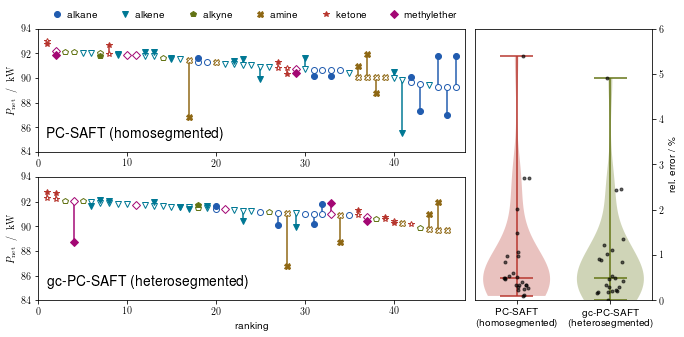

In [4]:
f = plt.figure(figsize=(11,5))
ax1 = plt.subplot2grid((2, 10), (0, 0), colspan=7)
ax2 = plt.subplot2grid((2, 10), (1, 0), colspan=7)
ax3 = plt.subplot2grid((2, 10), (0, 7), colspan=3, rowspan=2)

comparison_pcsaft = plot_comparison(ax1, ax3, 1, 'pcsaft', error_comps, True)
comparison_gc_pcsaft = plot_comparison(ax2, ax3, 1.7, 'gc-pcsaft', error_comps)

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('rel. error  /  \%')
ax3.set_ylim(0,6)
ax3.set_xticks([1,1.7], labels=['PC-SAFT\n(homosegmented)', 'gc-PC-SAFT\n(heterosegmented)']);

if output_directory is not None:
    plt.savefig(f'{output_directory}/ranking.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [5]:
all_components = {}
for comp in comparison_pcsaft:
    if comp['chemical'] not in all_components:
        all_components[comp['chemical']] = dict()
    all_components[comp['chemical']][comp['iupac_name']] = {'smiles': comp['smiles'], 'pcsaft': -comp['result']['target']}
    if comp['target_pcsaft'] is not None:
        all_components[comp['chemical']][comp['iupac_name']]['comparison'] = -comp['target_pcsaft']
for comp in comparison_gc_pcsaft:
    if comp['chemical'] not in all_components:
        all_components[comp['chemical']] = dict()
    if comp['iupac_name'] not in all_components[comp['chemical']]:
        all_components[comp['chemical']][comp['iupac_name']] = {'smiles': comp['smiles'], 'gc_pcsaft': -comp['result']['target']}
        if comp['target_pcsaft'] is not None:
            all_components[comp['chemical']][comp['iupac_name']]['comparison'] = -comp['target_pcsaft']
    else:
        all_components[comp['chemical']][comp['iupac_name']]['gc_pcsaft'] = -comp['result']['target']

if output_directory is not None:
    with open(f'{output_directory}/comparison.tex', 'w') as f:
        f.write("\\begin{scriptsize}\n\\begin{tabular}{|l|l|l|c|c|r|c|r|}\n\\hline\n")
        f.write("&&&& \\multicolumn{2}{c|}{PC-SAFT} & \\multicolumn{2}{c|}{gc-PC-SAFT} \\\\\n\\hline\n")
        f.write(" & iupac name & smiles & reference & $P_\\mathrm{net}~/~\mathrm{kW}$ & error / \%  & $P_\\mathrm{net}~/~\mathrm{kW}$ & error / \% \\\\\n\\hline\n")
        for chemical in sorted(all_components):
            f.write(f"\\multirow{{{len(all_components[chemical])}}}{{*}}{{{chemical}}}")
            for component in all_components[chemical]:
                comp = all_components[chemical][component]
                smiles = comp['smiles'].replace('#', '\\#')
                pcsaft = "" if 'pcsaft' not in comp else f"{comp['pcsaft']:.3f}"
                gc_pcsaft = "" if 'gc_pcsaft' not in comp else f"{comp['gc_pcsaft']:.3f}"
                comparison = "" if 'comparison' not in comp else f"{comp['comparison']:.3f}"
                error_pcsaft = "" if 'pcsaft' not in comp or 'comparison' not in comp else f"{(comp['pcsaft']/comp['comparison']-1)*100:.3f}"
                error_gc_pcsaft = "" if 'gc_pcsaft' not in comp or 'comparison' not in comp else f"{(comp['gc_pcsaft']/comp['comparison']-1)*100:.3f}"
                f.write(f" & {component} & \\tiny{{{smiles}}} & {comparison} & {pcsaft} & {error_pcsaft} & {gc_pcsaft} & {error_gc_pcsaft} \\\\\n")
            f.write("\\hline\n")
        f.write("\\end{tabular}\n\\end{scriptsize}")

In [6]:
if output_directory is not None:
    with open(f'{output_directory}/ranking.tex', 'w') as f:
        f.write("\\begin{tabular}{|r|l|l|c|l|l|c|}\n\\hline\n")
        f.write("& \\multicolumn{3}{c|}{PC-SAFT (homosegmented)} & \\multicolumn{3}{c|}{gc-PC-SAFT (heterosegmented)} \\\\\n\\hline\n")
        f.write("\\# & iupac name & smiles & $P_\\mathrm{net}~/~\mathrm{kW}$ & iupac name & smiles & $P_\\mathrm{net}~/~\mathrm{kW}$ \\\\\n\\hline\n")
        for i,(comp_gc_pcsaft, comp_pcsaft) in enumerate(zip(comparison_gc_pcsaft[:10], comparison_pcsaft[:10])):
            smiles_pcsaft = comp_pcsaft['smiles'].replace('#','\\#')
            smiles_gc_pcsaft = comp_gc_pcsaft['smiles'].replace('#','\\#')
            f.write(f"{i+1} & {comp_pcsaft['iupac_name']} & \\footnotesize{{{smiles_pcsaft}}} & {-comp_pcsaft['result']['target']:.3f} & {comp_gc_pcsaft['iupac_name']} & \\footnotesize{{{smiles_gc_pcsaft}}} & {-comp_gc_pcsaft['result']['target']:.3f}\\\\\n")
        f.write("\\hline\n\\end{tabular}")

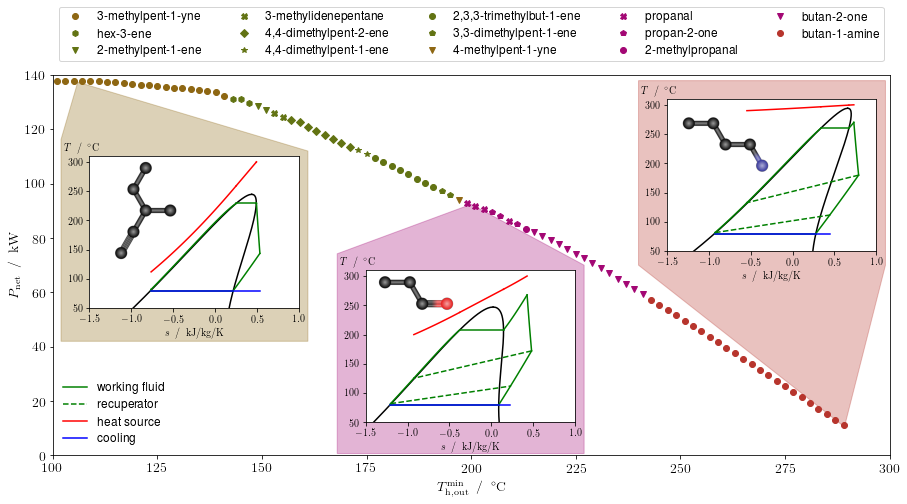

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

with open('pareto_front.json') as f:
    data = json.load(f)

f,ax = plt.subplots(figsize=(15,7))

comps = set((chem,comp) for chem,comp,_,_,_,_ in data[1::2])

count = Counter(chem for chem,_ in comps)
symbols = ['o', 'v', 'p', 'X', '*', 'D', 'h', '>']
symbols = list(s for c in sorted(count.keys()) for s in symbols[:count[c]])
symbols = dict((comp,s) for (_,comp),s in zip(sorted(comps),symbols))
    
all_chemicals = set(chemical for chemical,_,_,_,_,_ in data)
ETHcolors = [(98,115,19), (142,103,19), (183,53,45), (163,7,116)]
ETHcolors = [f"#{r:02x}{g:02x}{b:02x}" for r,g,b in ETHcolors]
colors = dict(zip(sorted(all_chemicals), ETHcolors))

legend_entries = set()
for chem,comp,_,p,t,r in data[1::2]:
    if t is None:
        continue
    if comp in legend_entries:
        label = None
    else:
        label = comp
        legend_entries.add(comp)
    plt.plot(t, -p, symbols[comp], color=colors[chem], label=label)
plt.axis([100,300,0,140])
leg = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand', ncol=5, fontsize=12)
plt.xlabel('$T_\mathrm{h,out}^\mathrm{min}~~/~~^\circ\mathrm{C}$', fontsize=14)
plt.ylabel('$P_\mathrm{net}~~/~~\mathrm{kW}$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

lines = [plt.plot([], [], line)[0] for line in ['g', '--g', 'r', 'b']]
plt.legend(lines, ['working fluid', 'recuperator', 'heat source', 'cooling'], fontsize=12, frameon=False)
ax.add_artist(leg)

def plot_ts(a, process, liquid, vapor, recuperator):
    a.plot(liquid['entropy [kJ/kg/K]'], liquid['temperature [°C]'], 'k')
    a.plot(vapor['entropy [kJ/kg/K]'], vapor['temperature [°C]'], 'k')
    for i,step in enumerate(process):
        a.plot(step['entropy [kJ/kg/K]'], step['temperature [°C]'], 'g')
        if step['utility temperature [°C]'] is not None:
            color = 'b' if min(step['utility temperature [°C]']) < 100 else 'r'
            a.plot(step['entropy [kJ/kg/K]'], step['utility temperature [°C]'], color)
    if recuperator:
        a.plot([process[i]['entropy [kJ/kg/K]'][0] for i in [3,4]], [process[i]['temperature [°C]'][0] for i in [3,4]], '--g')
        a.plot([process[i]['entropy [kJ/kg/K]'][0] for i in [2,7]], [process[i]['temperature [°C]'][0] for i in [2,7]], '--g')
    a.set_ylim(50,310)
    a.set_xlim(-1.5,1)
    a.set_xlabel('$s~~/~~\mathrm{kJ/kg/K}$')
    a.set_ylabel('$T~~/~~^\circ\mathrm{C}$', rotation='horizontal', ha='left', y=1.02)

axins1 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.05, 0.40, 0.25, 0.40), bbox_transform=ax.transAxes)
im_ax1 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.05, 0.34, 0.50, 0.66), bbox_transform=axins1.transAxes)
axins2 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.38, 0.10, 0.25, 0.40), bbox_transform=ax.transAxes)
im_ax2 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.05, 0.55, 0.4, 0.66), bbox_transform=axins2.transAxes)
axins3 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.74, 0.55, 0.25, 0.40), bbox_transform=ax.transAxes)
im_ax3 = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.0, 0.4, 0.60, 0.66), bbox_transform=axins3.transAxes)


for a, i, h, file in zip([im_ax1, im_ax2, im_ax3], [0,100,190], [300,100,80], ['alkyne.png', 'ketone.png', 'amine.png']):
    im = plt.imread(file)
    if file == 'alkyne.png':
        im = np.fliplr(im)
    a.imshow(im)
    a.axis('off')

with open('pareto_plots.json') as f:
    plot_data = json.load(f)
for a, (process, liquid, vapor), rec in zip([axins1, axins2, axins3], plot_data, [False, True, True]):
    plot_ts(a, process, liquid, vapor, rec)

ax.fill([0.01,0.03,0.305,0.305,0.01], [0.83,0.981,0.8,0.3,0.3], color=ETHcolors[1], alpha=0.3, transform=ax.transAxes)
ax.fill([0.34,0.5,0.635,0.635,0.34], [0.53,0.66,0.5,0.005,0.005], color=ETHcolors[3], alpha=0.3, transform=ax.transAxes)
ax.fill([0.7,0.946,0.995,0.995,0.7], [0.5,0.075,0.5,0.985,0.985], color=ETHcolors[2], alpha=0.3, transform=ax.transAxes)

if output_directory is not None:
    plt.savefig(f'{output_directory}/pareto.pdf', format='pdf', bbox_inches='tight', pad_inches=0, dpi=1200)